In [2]:
import sklearn
import keras
import sys
import time
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
import math
import cv2


from numpy import asarray
from numpy import clip

from PIL import Image

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dropout, Flatten, Dense, Bidirectional
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, Input, BatchNormalization, concatenate
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import shuffle

import skimage
from skimage import io
from skimage.transform import resize
from skimage.util import random_noise

from numpy.random import RandomState

In [3]:
def resize_image(image_path,size):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)  
    return img

In [4]:
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
import re

lemmatizer = WordNetLemmatizer() 
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(data):
    newData = []
    for title in data:
        title = re.sub(r'[0-9]+', '', title)
        new = " "
        for word in title.split(' '):
            
            if word not in stopwords:
                new += lemmatizer.lemmatize(word) + ' '
        newData.append(new)
        
    return newData

In [5]:
def getMaximumLen(data):
    maxL = 0
    for tweet in data:
        l = 0
        for word in tweet.split(' '):
            l += 1
        if (l>maxL):
            maxL = l    
    return maxL

In [6]:
columns = ["Image Path", "Title", "Category ID", "Category"]
data = pd.read_csv('train.csv', encoding = "ISO-8859-1", header=None,
                   usecols=[1,3,6,5], names=columns)

In [7]:
categories = sorted(data['Category'].unique())

In [8]:
paths = data['Image Path']
x = data['Title'].str.lower()
y = to_categorical(LabelEncoder().fit_transform(data['Category']), num_classes = 30 )
x = preprocess(x)

In [9]:
t = Tokenizer()
t.fit_on_texts(x)
wordIndex = t.word_index
vocab_size = len(wordIndex) + 1
maxlen = getMaximumLen(x)


In [10]:
import functools

top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

In [11]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [78]:
test = pd.read_csv('test.csv', header=None, usecols=[1,3,6,5], names=columns, encoding="latin1")

In [13]:
from keras.models import load_model

multimodal = load_model('multimodel.h5', custom_objects={'top3_acc': top3_acc, 'f1_m':f1_m})


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [74]:
def predict(n):
    sample = test.sample(n) 
    
    categorytest = []
    for i in sample['Category']:
        categorytest.append(i)

    categorytest = np.array(categorytest)
    
    pathtest= sample['Image Path']
    imagetest = []
    for i in pathtest:
        img = resize_image('dataset/'+i, 222)
        imagetest.append(img)
    imagetest = np.array(imagetest)

    xtest = preprocess(sample['Title'].str.lower())
    Xtest = t.texts_to_sequences(xtest)
    Xtest = pad_sequences(Xtest, maxlen=maxlen, padding='post')   
        
    y_pred = multimodal.predict([imagetest, Xtest]) 
    y_pred = np.argmax(y_pred, axis=1)
    
    count = 0
    for i in pathtest:
        image = cv2.imread('dataset/'+i)
        RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_im)
        plt.title('original image')
        plt.show()
        
        print(i)
        print("Prediction: ", categories[y_pred[count]])
        print("Real category: ", categorytest[count])
        count+=1

        

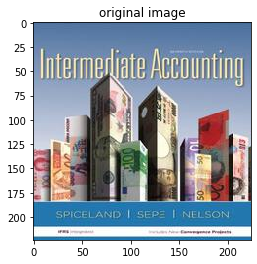

0077614046.jpg
Prediction:  Business & Money
Real category:  Computers & Technology


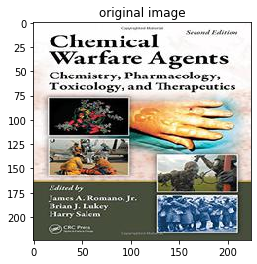

1420046616.jpg
Prediction:  Science & Math
Real category:  Medical Books


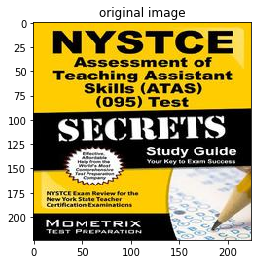

1610723384.jpg
Prediction:  Test Preparation
Real category:  Test Preparation


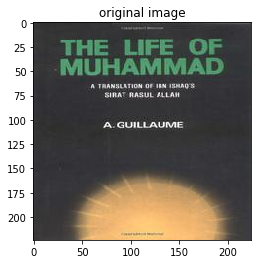

0196360331.jpg
Prediction:  Religion & Spirituality
Real category:  Biographies & Memoirs


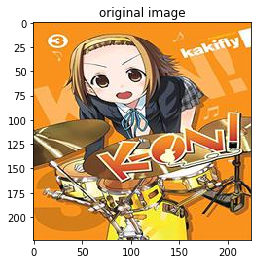

0316187623.jpg
Prediction:  Comics & Graphic Novels
Real category:  Teen & Young Adult


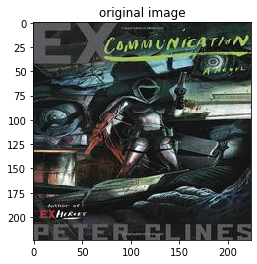

0385346824.jpg
Prediction:  Comics & Graphic Novels
Real category:  Science Fiction & Fantasy


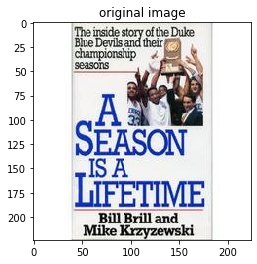

0671798111.jpg
Prediction:  Sports & Outdoors
Real category:  Sports & Outdoors


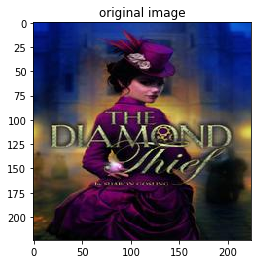

1630790028.jpg
Prediction:  Mystery, Thriller & Suspense
Real category:  Teen & Young Adult


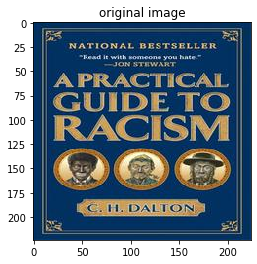

1592404308.jpg
Prediction:  Politics & Social Sciences
Real category:  Humor & Entertainment


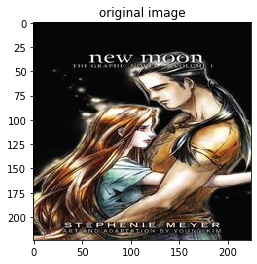

0316217182.jpg
Prediction:  Comics & Graphic Novels
Real category:  Comics & Graphic Novels


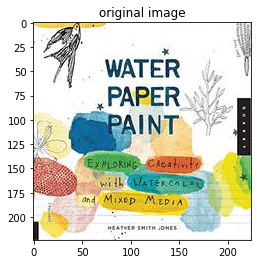

1592536557.jpg
Prediction:  Arts & Photography
Real category:  Crafts, Hobbies & Home


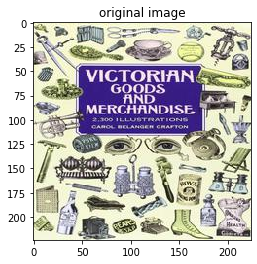

0486296989.jpg
Prediction:  Arts & Photography
Real category:  Arts & Photography


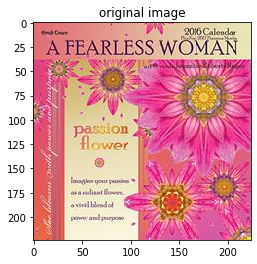

1610463706.jpg
Prediction:  Calendars
Real category:  Calendars


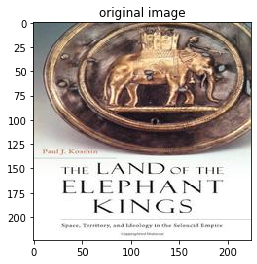

0674728823.jpg
Prediction:  History
Real category:  History


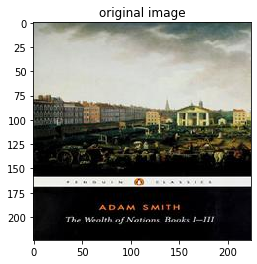

0140432086.jpg
Prediction:  Politics & Social Sciences
Real category:  Business & Money


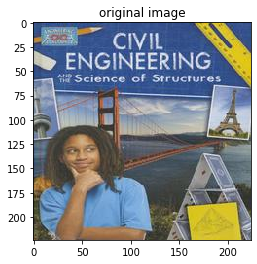

0778775011.jpg
Prediction:  Engineering & Transportation
Real category:  Teen & Young Adult


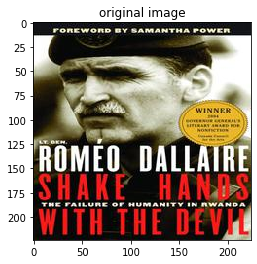

0786715103.jpg
Prediction:  History
Real category:  Law


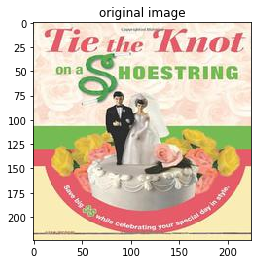

1592576109.jpg
Prediction:  Crafts, Hobbies & Home
Real category:  Crafts, Hobbies & Home


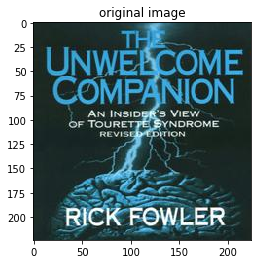

0964637693.jpg
Prediction:  Health, Fitness & Dieting
Real category:  Health, Fitness & Dieting


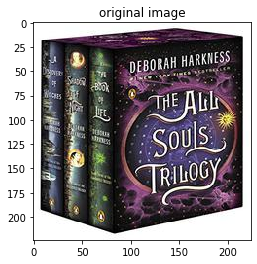

0147517729.jpg
Prediction:  Science Fiction & Fantasy
Real category:  Mystery, Thriller & Suspense


In [80]:
predict(20)